In [2]:
import multiprocessing
from pathlib import Path

from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
from datasets import DatasetDict
from IPython.display import Audio as display_audio

In [62]:
sanity_check = False

n_cpu = multiprocessing.cpu_count() - 5; n_cpu
data_path = Path("/data/volume")
audio_path = data_path / "audio"
audio_path.mkdir(parents=True, exist_ok=True)

## Load model

In [4]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

## Load Dataset

In [5]:
dataset_path = data_path / "tts-training-processed-phono"
dataset = DatasetDict.load_from_disk(dataset_path)
dataset

Loading dataset from disk:   0%|          | 0/91 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/23 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 160000
    })
    test: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 40000
    })
})

In [6]:
if sanity_check:
    dataset["train"] = dataset["train"].select(range(1000))
    dataset["test"] = dataset["test"].select(range(200))

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 200
    })
})

In [8]:
dataset["train"][0]

{'uni': 'དེང་སང་བོད་ཀྱི་ལྷོ་ཁའི་ཕྱོགས་སུ་སྲས་མཁར་དགུ་ཐོག་ཟེར་བའི་སྔོན་གྱི་མཁར་རྙིང་སྙན་གྲགས་ཅན་ཞིག་ཡོད་པ་དེ།',
 'sentence': 'téng  sang  pö  kyi  lo  kaɪ  chok  su  sè  kar  gu  tok  sèr  paɪ  ṅön  kyi  kar  nying  nyèn  ṭak  chèn  shik  yö  pa  té',
 'label': 'STT_AB',
 'speaker_id': '13c42bde-df0f-4feb-b795-c549f1844148',
 'duration': 7.172,
 'tokens_len': 122,
 'path': {'path': 'STT_AB00118_0008_60707_to_67879.wav',
  'array': array([0.00689697, 0.00675964, 0.00088501, ..., 0.00401306, 0.00462341,
         0.0070343 ]),
  'sampling_rate': 16000}}

In [9]:
def resolve_audio_path(item):
    item["path"] = str(audio_path / item["path"]["path"])
    return item

In [10]:
dataset = dataset.map(resolve_audio_path, num_proc=n_cpu)

In [11]:
dataset["train"][0]

{'uni': 'དེང་སང་བོད་ཀྱི་ལྷོ་ཁའི་ཕྱོགས་སུ་སྲས་མཁར་དགུ་ཐོག་ཟེར་བའི་སྔོན་གྱི་མཁར་རྙིང་སྙན་གྲགས་ཅན་ཞིག་ཡོད་པ་དེ།',
 'sentence': 'téng  sang  pö  kyi  lo  kaɪ  chok  su  sè  kar  gu  tok  sèr  paɪ  ṅön  kyi  kar  nying  nyèn  ṭak  chèn  shik  yö  pa  té',
 'label': 'STT_AB',
 'speaker_id': '13c42bde-df0f-4feb-b795-c549f1844148',
 'duration': 7.172,
 'tokens_len': 122,
 'path': {'path': '/data/volume/audio/STT_AB00118_0008_60707_to_67879.wav',
  'array': array([0.00689697, 0.00675964, 0.00088501, ..., 0.00401306, 0.00462341,
         0.0070343 ]),
  'sampling_rate': 16000}}

## Clean up the text

The dataset may contain characters that are not in the SpeechT5 tokenizer vocabulary. Those will be converted to `<unk>` tokens. However, in Dutch a character such as `à` is used to stress syllables and so we can simply replace it with `a` without changing its meaning. The tokenizer supports some characters with diacritical marks, such as `é`, but not all of them.

Note that the VoxPopuli examples have both `raw_text` and `normalized_text`, which is all lowercase. The SpeechT5 tokenizer can handle uppercase just fine, however, it doesn't have any tokens for numbers. The `normalized_text` has the numbers written out as text, so we'll use that.



First we'll need to find out what the unsupported tokens are. The `SpeechT5Tokenizer` works with characters as tokens, so let's extract all distinct characters of the dataset. We write a mapping function `extract_all_chars` that concatenates the transcriptions from all examples into one long transcription and then transforms the string into a set of characters. It is important to pass the arguments `batched=True` and `batch_size=-1` to `dataset.map(...)` so that the mapping function has access to all transcriptions at once.

In [12]:
tokenizer = processor.tokenizer
a = tokenizer.get_vocab().items()

In [13]:
def extract_all_chars(batch):
    all_text = " ".join(batch["sentence"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset['train'].map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset['train'].column_names,
)
vocabs = dataset['test'].map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset['test'].column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [14]:
len(dataset_vocab), len(tokenizer_vocab)

(31, 81)

In [15]:
dataset_vocab-tokenizer_vocab


{' ', 'è', 'ö', 'ü', 'ɪ', 'ʂ', 'ḍ', 'ṅ', 'ṭ'}

Next, we will define a function to map these characters to valid tokens and then run it on the dataset. No need to handle space, that's already replaced by `▁` in the tokenizer.

In [16]:
replacements = [
    ('è', 'e'),  # Similar to "e" in "bed"
    ('ö', 'oe'), # Similar to "o" in "bird" or "u" in "burn" (British accent)
    ('ü', 'u'),  # Similar to "u" in "lune" or "y" in "myth" with rounded lips
    ('ɪ', 'i'),  # Similar to "i" in "bit"
    ('ʂ', 'sh'), # Similar to "sh" in "sheep" with retroflexion
    ('ḍ', 'd'),  # Retroflex "d" similar to hard "d"
    ('ṅ', 'ng'), # Similar to "ng" in "sing"
    ('ṭ', 't'),  # Retroflex "t" similar to hard "t"
]
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["sentence"] = inputs["sentence"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text, num_proc=n_cpu)

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we'll need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [17]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device ="cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

/tmp/ipykernel_56069/2420507585.py:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier
/home/jovyan/.conda/envs/jupyter-base/lib/python3.11/site-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
/home/jovyan/.conda/envs/jupyter-base/lib/python3.11/site-packages/speechbrain/utils/checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See ht

Note: the `speechbrain/spkrec-xvect-voxceleb` model was trained on English speech from the VoxCeleb dataset, while our training examples are in Dutch. We're assuming here that this model will still make reasonable speaker embeddings, but this may not be true. First training an X-vector model on the target speech, such as Dutch, might work better.

## Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

In [18]:
def prepare_dataset(batch):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio_batch = batch["path"]
    sentence_batch = batch["sentence"]
    audio_array_batch = [audio["array"] for audio in audio_batch]
    sampling_rate = audio_batch[0]["sampling_rate"]

    example = processor(
        text=sentence_batch,
        audio_target=audio_array_batch,
        sampling_rate=sampling_rate,
        return_attention_mask=False,
    )

    example["sentence"] = sentence_batch
    example["labels"] = [label for label in example["labels"]]
    example["path"] = audio_batch
    example["speaker"] = batch['speaker_id']
    example["uni"] = batch["uni"]
    example["speaker_embeddings"] = [create_speaker_embedding(array) for array in audio_array_batch]

    return example

Let's verify the processing is correct by looking at a single example:

In [19]:
processed_example = prepare_dataset(dataset['train'].select(range(5)))
processed_example["speaker_embeddings"][0].shape

(512,)

In [20]:
processed_example["labels"][0].shape

(449, 80)

In [21]:
processed_example["uni"]

['དེང་སང་བོད་ཀྱི་ལྷོ་ཁའི་ཕྱོགས་སུ་སྲས་མཁར་དགུ་ཐོག་ཟེར་བའི་སྔོན་གྱི་མཁར་རྙིང་སྙན་གྲགས་ཅན་ཞིག་ཡོད་པ་དེ།',
 'དེ་འདྲས་ཕྱི་རོལ་པ་དང་ནང་པ་ཡི།',
 'དེ་ལྟ་ན་',
 'རང་གཞན་མཐའ་དག་འདི་ཕྱི་ཀུན་ཏུ་དགེ་བའི་ལམ་བཟང་ལ་ཞུགས་ཐུབ་ན་མི་ཚེ་དོན་ལྡན་དུ་འགྱུར་བ་ཡིན་པས་མ་འཕྱུགས་པ་དགོས་',
 'བསྟོད་བསྔགས་ཀྱི་གཞས་ཚིག་རྩོམ་པ་ཞེས་འཁོད་ཡོད།']

This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [22]:
list(processed_example.keys())

['input_ids',
 'labels',
 'sentence',
 'path',
 'speaker',
 'uni',
 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [23]:
[tokenizer.decode(input_ids) for input_ids in processed_example["input_ids"]]

['téng sang poe kyi lo kai chok su se kar gu tok ser pai ngoen kyi kar nying nyen tak chen shik yoe pa té</s>',
 'té de chi roel pa tang nang pa yi</s>',
 'té ta na</s>',
 'rang shen ta tak di chi kun tu gé pai lam sang la shuk tup na mi tsé toen den tu gyur pa yin pe ma chuk pa goe</s>',
 'toe ngak kyi she tsik tsom pa she koe yoe</s>']

Speaker embeddings should be a 512-element vector:

In [24]:
processed_example["speaker_embeddings"][0].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

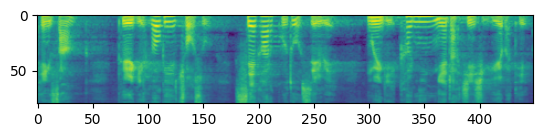

In [25]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"][0].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [26]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [28]:
i = 3
print(processed_example["uni"][i])
print(processed_example["sentence"][i])
spectrogram = torch.tensor(processed_example["labels"][i])
with torch.no_grad():
    speech = vocoder(spectrogram)
display_audio(speech.cpu().numpy(), rate=16000)

རང་གཞན་མཐའ་དག་འདི་ཕྱི་ཀུན་ཏུ་དགེ་བའི་ལམ་བཟང་ལ་ཞུགས་ཐུབ་ན་མི་ཚེ་དོན་ལྡན་དུ་འགྱུར་བ་ཡིན་པས་མ་འཕྱུགས་པ་དགོས་
rang  shen  ta  tak  di  chi  kun  tu  gé  pai  lam  sang  la  shuk  tup  na  mi  tsé  toen  den  tu  gyur  pa  yin  pe  ma  chuk  pa  goe


In [29]:
dataset["train"][0]["uni"]

'དེང་སང་བོད་ཀྱི་ལྷོ་ཁའི་ཕྱོགས་སུ་སྲས་མཁར་དགུ་ཐོག་ཟེར་བའི་སྔོན་གྱི་མཁར་རྙིང་སྙན་གྲགས་ཅན་ཞིག་ཡོད་པ་དེ།'

That all looks and sounds good! We can now process the entire dataset. This will take between 5 and 10 minutes.

In [30]:
dataset['train'].column_names

['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path']

In [31]:
dataset = dataset.map(
    prepare_dataset,
    remove_columns=dataset['train'].column_names,
    batched=True,
    batch_size=32
)

In [33]:
dataset['train'].column_names

['uni',
 'sentence',
 'path',
 'input_ids',
 'labels',
 'speaker',
 'speaker_embeddings']

In [35]:
import random
i = random.choice(range(len(dataset["train"])))
print(dataset["train"][i]["uni"])
print(dataset["train"][i]["sentence"])
spectrogram = torch.tensor(dataset["train"][i]["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)
display_audio(speech.cpu().numpy(), rate=16000)

དང་། བསམ་ཕོ་རྨ་རྨས་བྱུང་བར་དགོངས་འགལ་མེད་པའི་ཐོག་ཁོང་ལ་དགོངས་སེལ་མཚོན་བྱེད་ཅིག་ཀྱང་བཀའ་ཤག་བརྒྱུད་འབུལ་བསྐུར་ཞུས་འདུག
tang  sam  po  ma  me  chung  par  gong  gel  me  pai  tok  kong  la  gong  sel  tsoen  che  chik  kyang  ka  shak  gyu  bul  kur  shu  duk


## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [36]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [37]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Let's test the data collator.

In [38]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [39]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 146]),
 'attention_mask': torch.Size([3, 146]),
 'labels': torch.Size([3, 668, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

Looks good!

## Training

It's always a good idea to upload model checkpoints directly to the [Hugging Face Hub](https://huggingface.co/) while training. To allow this, first log in to the Hub by entering your Hub authentication token:

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [40]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [58]:
models_path = data_path / "models" / "exp3"
models_path.mkdir(exist_ok=True, parents=True)

model_name = "TTS_st5_phono_160k"
model_path = models_path / model_name

In [59]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=str(model_path),
    per_device_train_batch_size=64,
    gradient_accumulation_steps=1,
    num_train_epochs=30,
    learning_rate=1e-5,
    warmup_steps=500,
    gradient_checkpointing=False,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    save_steps=3000,
    eval_steps=2000,
    logging_steps=5,
    save_total_limit=10,
    report_to=["wandb"],
    label_names=["labels"],
)

/home/jovyan/.conda/envs/jupyter-base/lib/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer object using the model, dataset, and data collator.

In [60]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)
torch.cuda.empty_cache()

/tmp/ipykernel_56069/54815936.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


And with that, we're ready to start training!

Training will take several hours depending on your GPU or the one allocated to the Google Colab. Depending on your GPU, it is possible that you will encounter a CUDA "out-of-memory" error when you start training. In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2 and increase `gradient_accumulation_steps` by 2x to compensate.

In [61]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=1, training_loss=12.11713981628418, metrics={'train_runtime': 33.4971, 'train_samples_per_second': 29.853, 'train_steps_per_second': 0.03, 'total_flos': 139219410078144.0, 'train_loss': 12.11713981628418, 'epoch': 1.0})

If we do one more `push_to_hub()` after training we can get a nice model card built for us. We simply have to set the appropriate keyword arguments (kwargs). You can change these values to match your dataset, language and model name accordingly:

You can now share this model with anyone using the link on the Hub.

In [49]:
model.push_to_hub(model_name)

pytorch_model.bin:   0%|          | 0.00/578M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/spsitherMonlamAI/TTS_AB-all_run2/commit/ef311f60f14f98ce4fde289d924184107c21fc91', commit_message='Upload SpeechT5ForTextToSpeech', commit_description='', oid='ef311f60f14f98ce4fde289d924184107c21fc91', pr_url=None, pr_revision=None, pr_num=None)